In [25]:
import gensim
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import pandas as pd

In [27]:
df= pd.read_csv("drive/My Drive/Colab Notebooks/LSTM Workings/Datasets/trainpreprocessed.csv")

In [28]:
df_test=pd.read_csv("drive/My Drive/Colab Notebooks/LSTM Workings/Datasets/testpreprocessed.csv")
df_val=pd.read_csv("drive/My Drive/Colab Notebooks/LSTM Workings/Datasets/valpreprocessed.csv")

In [29]:
df['label'] = df.label.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

In [30]:
df_test['label'] = df_test.label.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

In [31]:
df_val['labels'] = df_val.labels.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

In [32]:
from keras.utils import to_categorical
y_train = to_categorical(df.label.values)
y_test = to_categorical(df_test.label.values)
y_val = to_categorical(df_val.labels.values)

In [33]:
from keras.preprocessing.text import Tokenizer
num_words = 10000

In [34]:
tokenizer=Tokenizer(num_words,lower=True)
df_total = pd.concat([df['sentences'], df_test.sentences], axis = 0)
tokenizer.fit_on_texts(df_total)

In [35]:
from keras.utils import pad_sequences

In [36]:
X_train=tokenizer.texts_to_sequences(df['sentences']) # this converts texts into some numeric sequences 
X_train_pad=pad_sequences(X_train,maxlen=300,padding='post') # this makes the length of all numeric sequences equal 
X_test = tokenizer.texts_to_sequences(df_test.sentences)
X_test_pad = pad_sequences(X_test, maxlen = 300, padding = 'post')
X_val = tokenizer.texts_to_sequences(df_val.sentences)
X_val_pad = pad_sequences(X_val, maxlen = 300, padding = 'post')

In [37]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-300')

In [39]:
import numpy as np
from gensim.models import KeyedVectors

In [40]:
vector_size = 300
gensim_weight_matrix = np.zeros((num_words ,vector_size))
gensim_weight_matrix.shape
for word, index in tokenizer.word_index.items():
    if index < num_words: # since index starts with zero 
        if word in glove_gensim.key_to_index:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(300)

In [41]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
import tensorflow

In [43]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
import tensorflow
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [44]:
EMBEDDING_DIM = 300
class_num = 6
model = Sequential()


model.add(Embedding(input_dim=num_words, 
                    output_dim=EMBEDDING_DIM, 
                    input_length=X_train_pad.shape[1], 
                    weights=[gensim_weight_matrix], 
                    trainable=True))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(100,return_sequences=True, kernel_regularizer=regularizers.l2(0.01))))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(100,return_sequences=True, kernel_regularizer=regularizers.l2(0.01))))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(100,return_sequences=False, kernel_regularizer=regularizers.l2(0.01))))
model.add(Dense(class_num, activation='softmax'))
from tensorflow.keras.optimizers import Adam
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [45]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [46]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [47]:
history_embedding = model.fit(X_train_pad, y_train, 
                                epochs = 50, batch_size = 300, 
                                validation_data=(X_val_pad, y_val),
                                verbose = 1, 
                                callbacks= [es, mc]  
                              )

Epoch 1/50
54/54 [==============================] - ETA: 0s - loss: 17.8338 - accuracy: 0.3301
Epoch 1: val_accuracy improved from -inf to 0.35850, saving model to ./model.h5
54/54 [==============================] - 37s 523ms/step - loss: 17.8338 - accuracy: 0.3301 - val_loss: 16.4442 - val_accuracy: 0.3585
Epoch 2/50
54/54 [==============================] - ETA: 0s - loss: 15.2784 - accuracy: 0.3606
Epoch 2: val_accuracy improved from 0.35850 to 0.39250, saving model to ./model.h5
54/54 [==============================] - 19s 348ms/step - loss: 15.2784 - accuracy: 0.3606 - val_loss: 14.1134 - val_accuracy: 0.3925
Epoch 3/50
54/54 [==============================] - ETA: 0s - loss: 13.0870 - accuracy: 0.4279
Epoch 3: val_accuracy improved from 0.39250 to 0.49200, saving model to ./model.h5
54/54 [==============================] - 18s 338ms/step - loss: 13.0870 - accuracy: 0.4279 - val_loss: 12.0188 - val_accuracy: 0.4920
Epoch 4/50
54/54 [==============================] - ETA: 0s - loss:

In [48]:
model.save('drive/My Drive/Colab Notebooks/Analytics Bidhya each step/analytics.h5')

In [49]:
import matplotlib.pyplot as plt

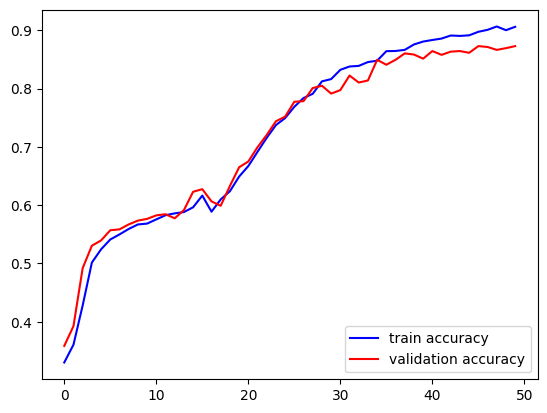

In [50]:
plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

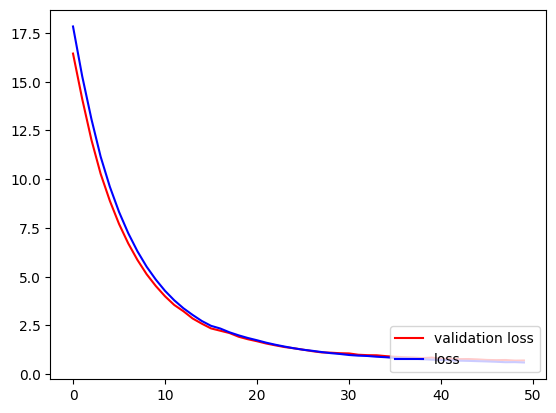

In [51]:
plt.plot(history_embedding.history['val_loss'],c='r',label='validation loss')
plt.plot(history_embedding.history['loss'],c='b',label='loss')
plt.legend(loc='lower right')
plt.show()

In [52]:
model.summary()
print(model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          3000000   
                                                                 
 dropout_3 (Dropout)         (None, 300, 300)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 300, 200)         321600    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 300, 200)          0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 300, 200)         241600    
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 300, 200)         